n_eval: 365

=== BASELINE ===
MAE : 87.41068109863015
RMSE: 112.7047122796886
WAPE: 0.5201012405985076

=== PROPHET ===
MAE : 63.44197409218354
RMSE: 79.47589503384384
WAPE: 0.37748532578223026


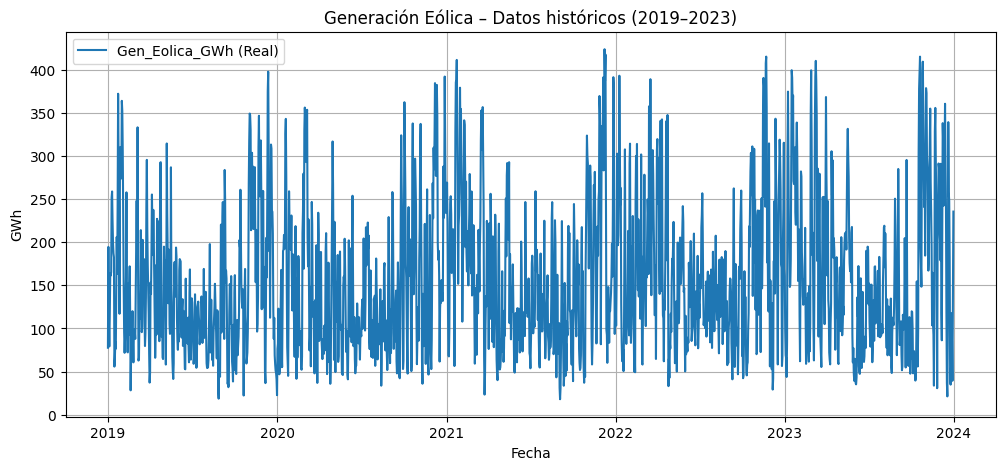

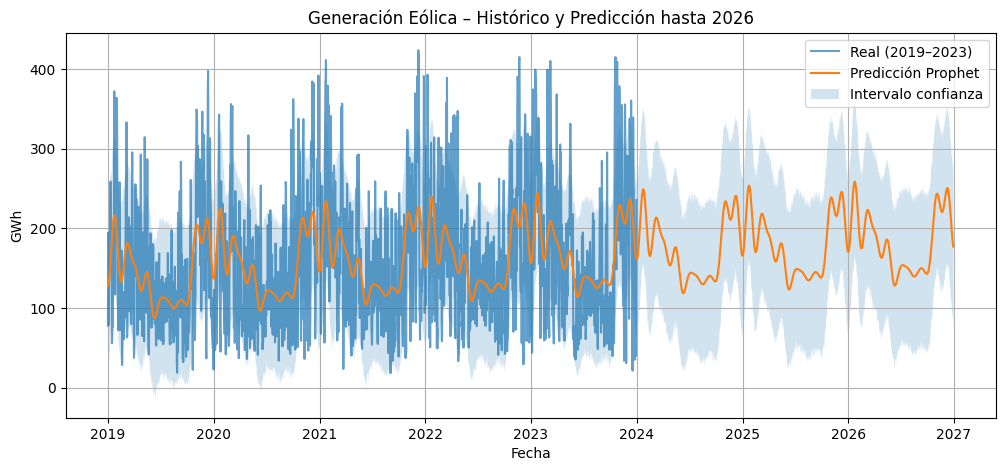

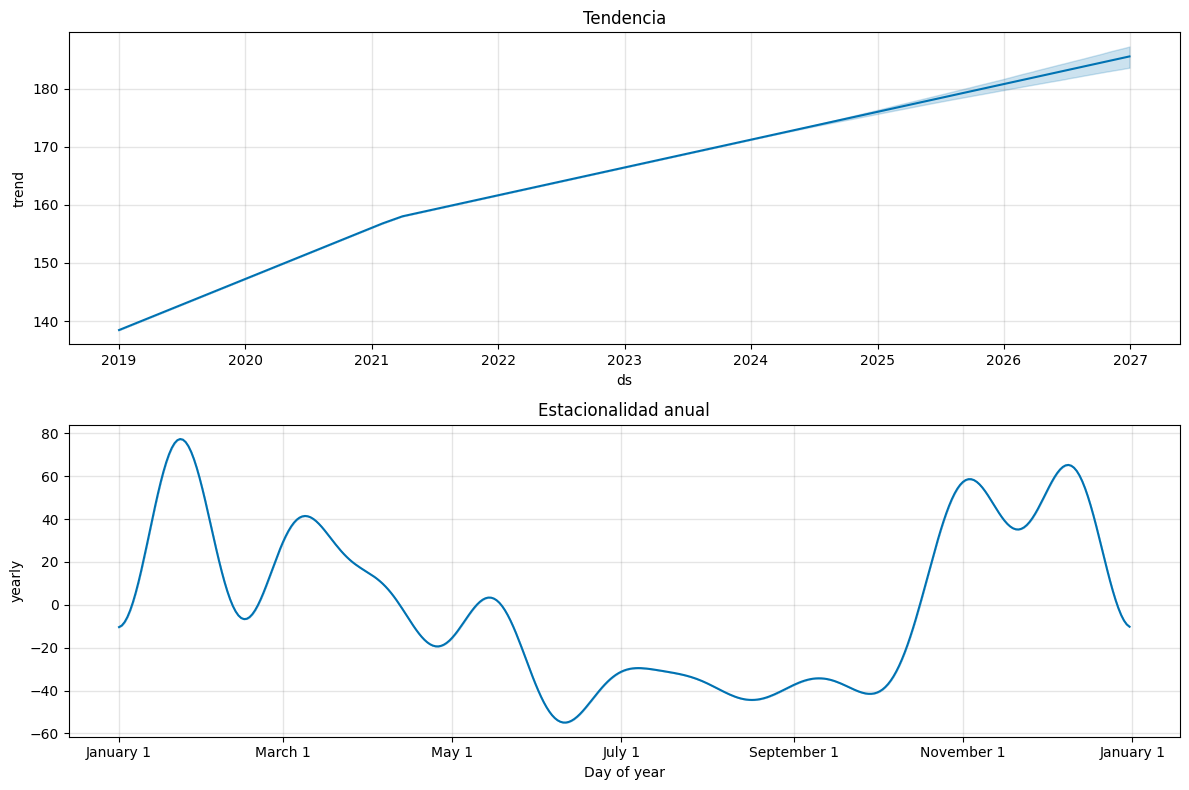

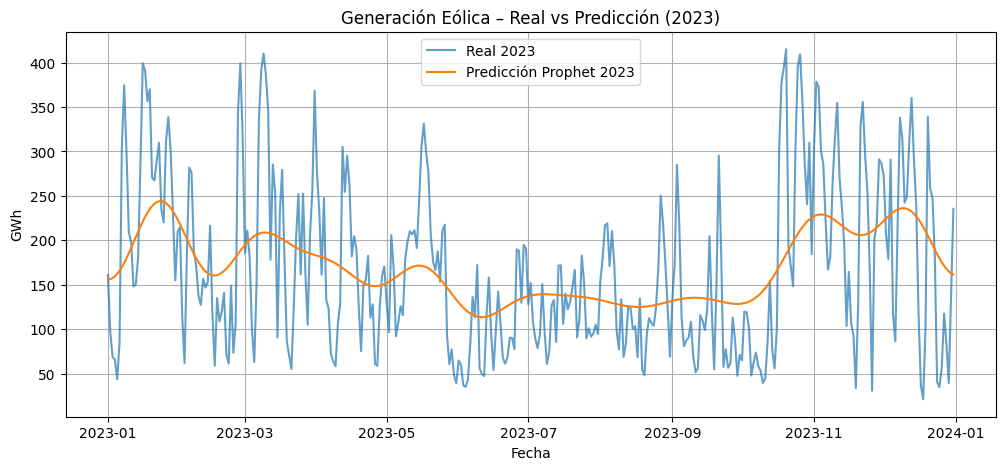

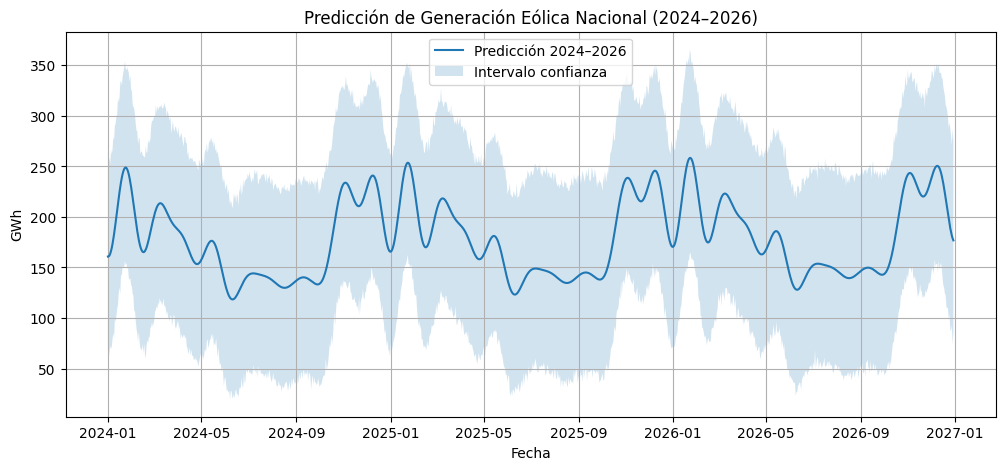

['Modelo_Gen_Eolica.joblib']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib


df = pd.read_csv("SET_INPUTS_BASE_0.csv")

df["ds"] = pd.to_datetime(df[["Year", "Month", "Day"]])
df["y"] = df["Gen_Eolica_GWh"]

df_prophet = df[["ds", "y"]].sort_values("ds")


# Entrenamiento modelo prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(df_prophet)


# Crear fechas futuras hasta 2026
future = model.make_future_dataframe(
    periods=3 * 365,
    freq="D"
)

# Eliminar 29 de febrero
future = future[
    ~((future["ds"].dt.month == 2) & (future["ds"].dt.day == 29))
]

forecast = model.predict(future)

# Baseline + metricas (validación 2023)


#Train / Test
train = df_prophet[df_prophet["ds"] < "2023-01-01"]
test  = df_prophet[
    (df_prophet["ds"] >= "2023-01-01") &
    (df_prophet["ds"] <= "2023-12-31")
]

# Predicción Prophet 2023
future_test = model.make_future_dataframe(periods=365, freq="D")
forecast_test = model.predict(future_test)

pred_2023 = forecast_test[
    (forecast_test["ds"] >= "2023-01-01") &
    (forecast_test["ds"] <= "2023-12-31")
][["ds", "yhat"]].sort_values("ds")

# Baseline: mismo día del año anterior (2022 → 2023)
baseline = train.copy()
baseline["ds"] = baseline["ds"] + pd.DateOffset(years=1)
baseline = baseline[
    baseline["ds"].between("2023-01-01", "2023-12-31")
][["ds", "y"]].sort_values("ds")

#  Dataset de evaluación alineado
df_eval = (
    test[["ds", "y"]]
    .merge(pred_2023, on="ds", how="inner")
    .merge(baseline.rename(columns={"y": "y_base"}), on="ds", how="inner")
)

y_true = df_eval["y"].values
y_prophet = df_eval["yhat"].values
y_base = df_eval["y_base"].values

# Métricas
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y))

print("n_eval:", len(df_eval))

print("\n=== BASELINE ===")
print("MAE :", mean_absolute_error(y_true, y_base))
print("RMSE:", rmse(y_true, y_base))
print("WAPE:", wape(y_true, y_base))

print("\n=== PROPHET ===")
print("MAE :", mean_absolute_error(y_true, y_prophet))
print("RMSE:", rmse(y_true, y_prophet))
print("WAPE:", wape(y_true, y_prophet))


# Graficos


# Histórico 2019–2023
plt.figure(figsize=(12, 5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Gen_Eolica_GWh (Real)")
plt.title("Generación Eólica – Datos históricos (2019–2023)")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.show()

# Histórico + Predicción
plt.figure(figsize=(12, 5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Real (2019–2023)", alpha=0.7)
plt.plot(forecast["ds"], forecast["yhat"], label="Predicción Prophet")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.2,
    label="Intervalo confianza"
)
plt.title("Generación Eólica – Histórico y Predicción hasta 2026")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.show()

# Componentes del modelo
fig = model.plot_components(forecast, figsize=(12, 8))
for ax in fig.axes:
    ax.grid(True)
fig.axes[0].set_title("Tendencia")
if len(fig.axes) > 1:
    fig.axes[1].set_title("Estacionalidad anual")
plt.tight_layout()
plt.show()

# Real vs Predicción (2023)
real_2023 = df_prophet[
    (df_prophet["ds"] >= "2023-01-01") &
    (df_prophet["ds"] <= "2023-12-31")
]

pred_2023 = forecast[
    (forecast["ds"] >= "2023-01-01") &
    (forecast["ds"] <= "2023-12-31")
]

plt.figure(figsize=(12, 5))
plt.plot(real_2023["ds"], real_2023["y"], label="Real 2023", alpha=0.7)
plt.plot(pred_2023["ds"], pred_2023["yhat"], label="Predicción Prophet 2023")
plt.title("Generación Eólica – Real vs Predicción (2023)")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.show()

# Predicción 2024–2026
pred_2024_2026_plot = forecast[
    (forecast["ds"] >= "2024-01-01") &
    (forecast["ds"] <= "2026-12-31")
]

plt.figure(figsize=(12, 5))
plt.plot(pred_2024_2026_plot["ds"], pred_2024_2026_plot["yhat"],
         label="Predicción 2024–2026")
plt.fill_between(
    pred_2024_2026_plot["ds"],
    pred_2024_2026_plot["yhat_lower"],
    pred_2024_2026_plot["yhat_upper"],
    alpha=0.2,
    label="Intervalo confianza"
)
plt.title("Predicción de Generación Eólica Nacional (2024–2026)")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.show()


# Exportar a csv y creación del joblib

pred_2024_2026 = forecast[
    (forecast["ds"] >= "2024-01-01") &
    (forecast["ds"] <= "2026-12-31")
].copy()

pred_2024_2026["Year"]  = pred_2024_2026["ds"].dt.year
pred_2024_2026["Month"] = pred_2024_2026["ds"].dt.month
pred_2024_2026["Day"]   = pred_2024_2026["ds"].dt.day

pred_2024_2026["Gen_Eolica_GWh"] = pred_2024_2026["yhat"]

pred_gen_eolica_2024_2026_final = pred_2024_2026[
    ["Year", "Month", "Day", "Gen_Eolica_GWh"]
]

pred_gen_eolica_2024_2026_final.to_csv(
    "pred_gen_eolica_2024_2026.csv",
    index=False
)

pred_gen_eolica_2024_2026_final.head()
joblib.dump(model, "Modelo_Gen_Eolica.joblib")
